## Ethan Chung

### Resources
- https://www.tensorflow.org/guide/keras/working_with_rnns
- https://www.tensorflow.org/tutorials/load_data/text

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from tensorflow.keras import layers, losses, callbacks, utils
from tensorflow.keras.layers import TextVectorization

import string
import re
import nltk
# nltk.download('stopwords')

tf.config.list_physical_devices('GPU')

2024-10-10 13:52:29.610899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 13:52:29.626486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 13:52:29.643376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 13:52:29.648441: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 13:52:29.661017: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load dataset

In [2]:
batch_size = 512
seed = 42

# Set 80% train, 20% validation split.
raw_train_ds = utils.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = utils.text_dataset_from_directory(
    "./train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

raw_train_ds_2 = raw_train_ds
raw_val_ds_2 = raw_val_ds

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2024-10-10 13:52:34.146476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14763 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Question:  b'Upon seeing this film once again it appeared infinitely superior to me this time than the previous times I have viewed it. The acting is stunningly wonderful. The characters are very clearly drawn. Brad Pitt is simply superb as the errant son who rebels. The other actors and actresses are equally fine in every respect. Robert Redford creates a wonderful period piece from the days of speakeasies of the 1920s. The scenery is incredibly beautiful of the mountains and streams of western Montana. All in all, this is one of the finest films made in the 1990s.<br /><br />You must see this movie!<br /><br />'
Label: 1
Question:  b"Italian-born Eleonora has inherited from her deceased lover Karl, an ultra-modern and isolated house in the middle of the woods. It's winter and she meets the mysterious caretaker Leslie, who eventually ends up not only just looking after the house, but also that of Eleonora, as s

2024-10-10 13:52:35.919732: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
raw_test_ds = utils.text_dataset_from_directory(
    "./test",
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [4]:
# Keep dataset in-memory so we don't have to keep fetching it from disk.
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Data preprocessing
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
- https://tracyrenee61.medium.com/how-to-use-tensorflows-textvectorization-function-to-perform-sentiment-analysis-on-tweets-438c06e6d2af


In [5]:
swords = nltk.corpus.stopwords.words("english")

def standardize(input_data):
  lowercase = tf.strings.lower(input_data)
  strip_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  strip_punctuation = tf.strings.regex_replace(strip_html, '[%s]' % re.escape(string.punctuation), '')
  strip_stopwords = tf.strings.regex_replace(strip_punctuation, r'\b(' + r'|'.join(swords) + r')\b\s*', '')
  # print(strip_stopwords)
  return strip_stopwords

vectorize_layer = TextVectorization(
    max_tokens=10000,
    standardize=standardize,
    output_sequence_length=100,
    output_mode='int')

# discard the labels, so only keeping text.
train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

# look at the first one and see how it was vectorized
first_vectorize_layer = vectorize_layer(first_question).numpy()
print("'int' vectorized question:", first_vectorize_layer)

for _,i in enumerate(first_vectorize_layer):
    if i == 0: 
        continue
    print(vectorize_layer.get_vocabulary()[i])

sample_input = ["This is a sample sentence."]
vectorized_sample = vectorize_layer(sample_input)

2024-10-10 13:52:38.644462: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Question: tf.Tensor(b"I can't believe that those praising this movie herein aren't thinking of some other film. I was prepared for the possibility that this would be awful, but the script (or lack thereof) makes for a film that's also pointless. On the plus side, the general level of craft on the part of the actors and technical crew is quite competent, but when you've got a sow's ear to work with you can't make a silk purse. Ben G fans should stick with just about any other movie he's been in. Dorothy S fans should stick to Galaxina. Peter B fans should stick to Last Picture Show and Target. Fans of cheap laughs at the expense of those who seem to be asking for it should stick to Peter B's amazingly awful book, Killing of the Unicorn.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int32)
'int' vectorized question: [  81  155    1    2 9197  578  410    3 2727 3880    9  260  127  446
 8641   68    3   84   16  990  821  395  663  550 3455   77   62 1490
  920   83 2978 

(0.0, 60.0)

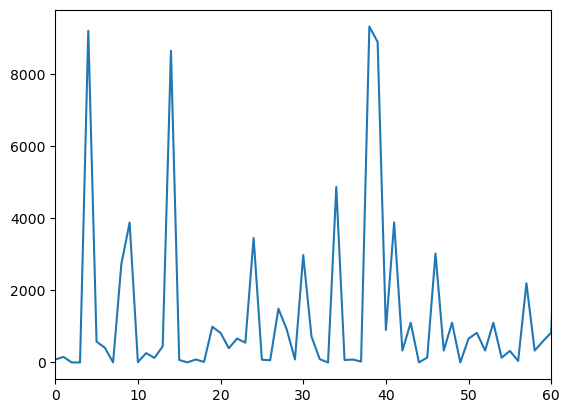

In [6]:
plt.plot(first_vectorize_layer)
plt.xlim(0,60)

## create model architecture
ablation study in LSTM dropout layer:
- A: recurrent 0.5, dropout 0.5 
- B: recurrent 0.5, dropout 0 (current)
- C: recurrent 0, dropout 0

In [7]:
int_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=10000, output_dim=64),
    layers.LSTM(128, recurrent_dropout=0.5),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'), # 128 to 64
    layers.Dropout(0.25), 
    layers.Dense(32, activation='relu'), # 64 to 32
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')  # prediction between 0 and 1
])

int_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

## train model

In [8]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

int_history = int_model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    batch_size=batch_size,
    epochs=25,
    callbacks=[early_stopping]
)

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.5015 - loss: 0.6934 - val_accuracy: 0.5230 - val_loss: 0.6929
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5430 - loss: 0.6851 - val_accuracy: 0.7286 - val_loss: 0.5576
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.7362 - loss: 0.5808 - val_accuracy: 0.7480 - val_loss: 0.5548
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7771 - loss: 0.5298 - val_accuracy: 0.7866 - val_loss: 0.5029
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.8076 - loss: 0.4990 - val_accuracy: 0.8008 - val_loss: 0.5082
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7899 - loss: 0.5310 - val_accuracy: 0.6854 - val_loss: 0.5983
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7288 - loss: 0.5596 - val_accuracy: 0.7240 - val_loss: 0.5625
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7706 - loss: 0.5383 - val_accuracy: 0.

## plot model diagram

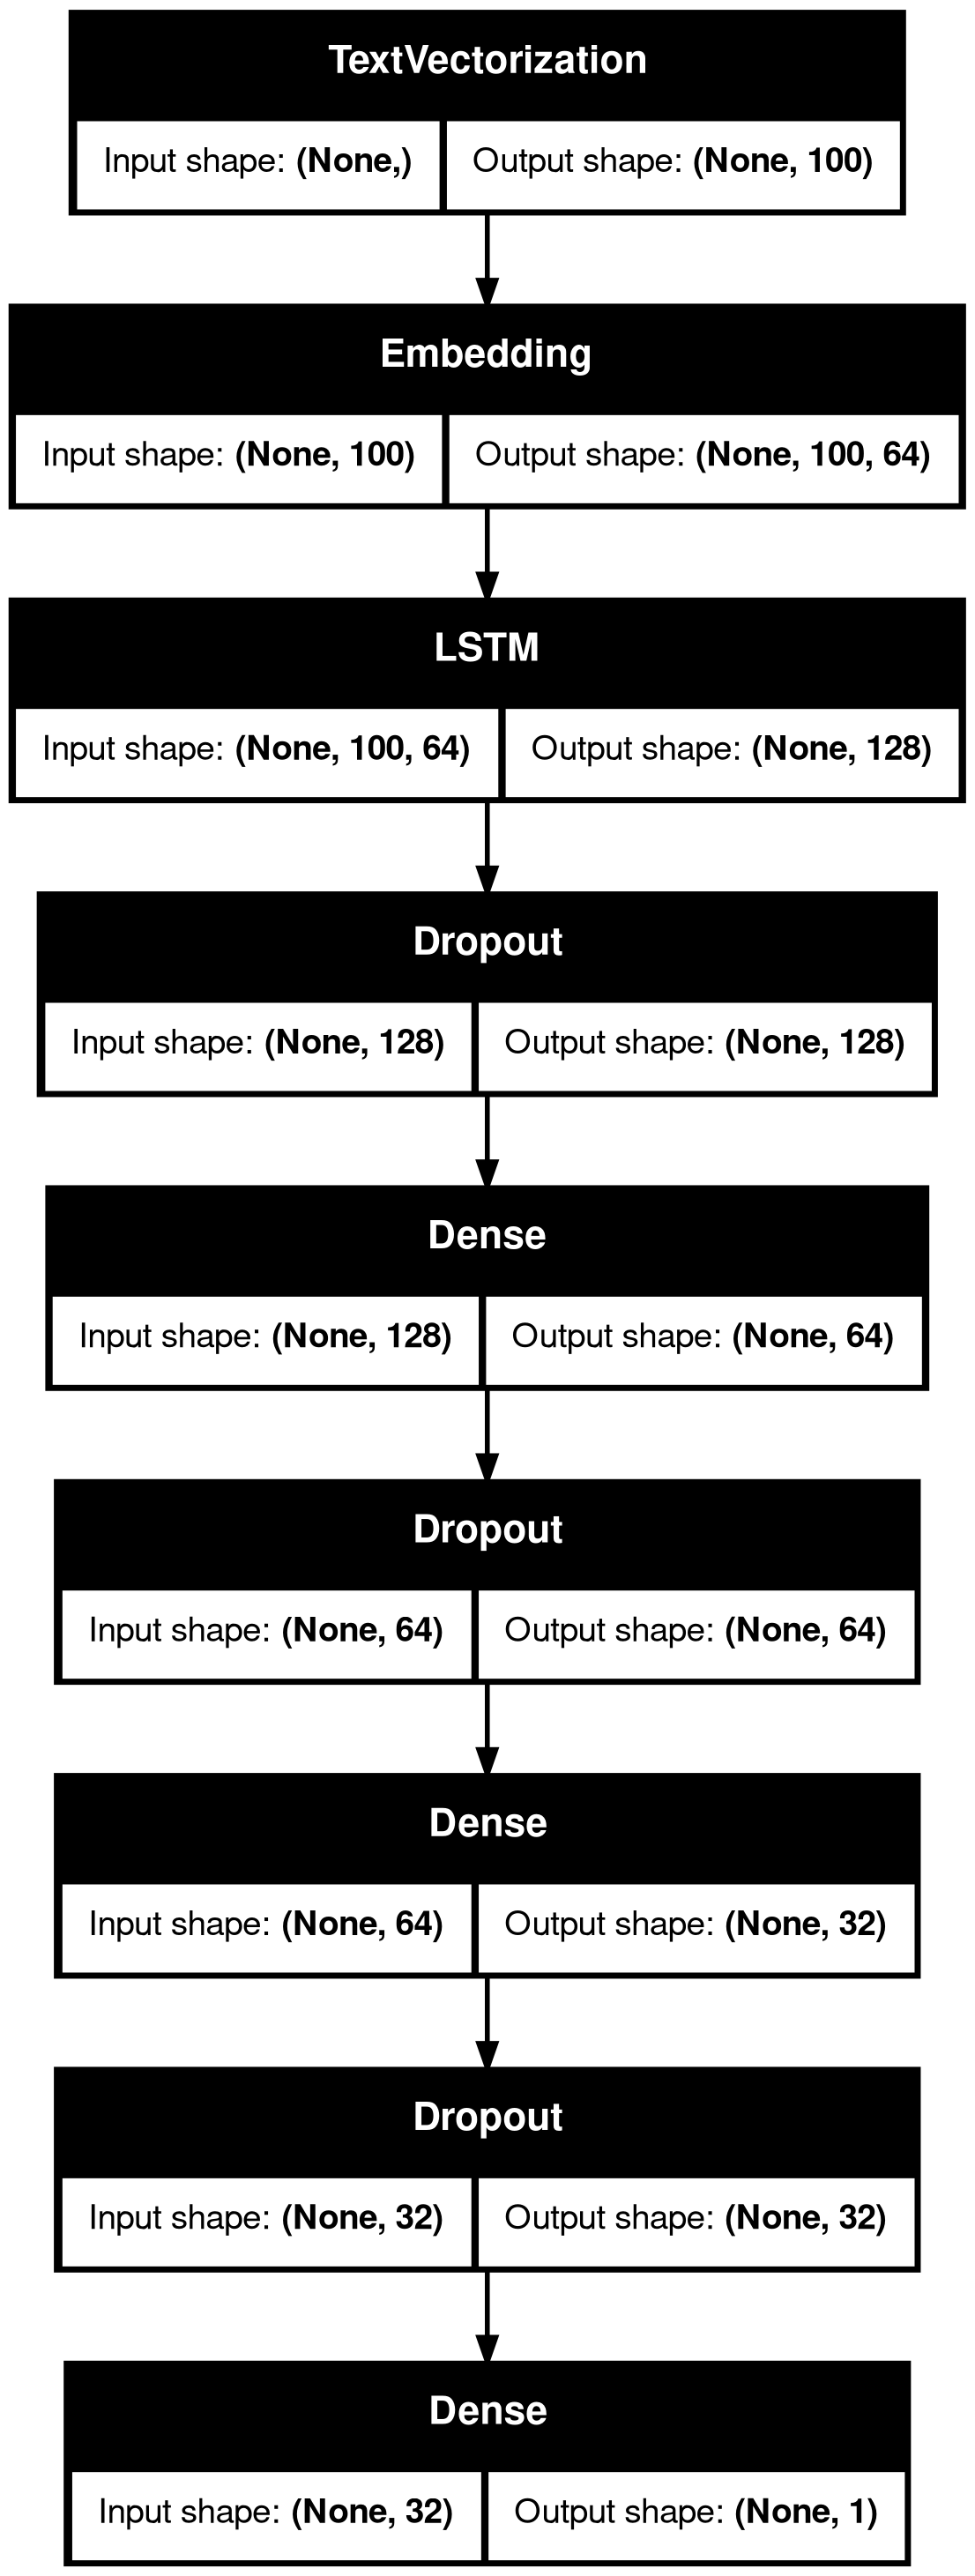

In [9]:
utils.plot_model(int_model, show_shapes=True)

# plot loss to epochs

Text(0, 0.5, 'Loss')

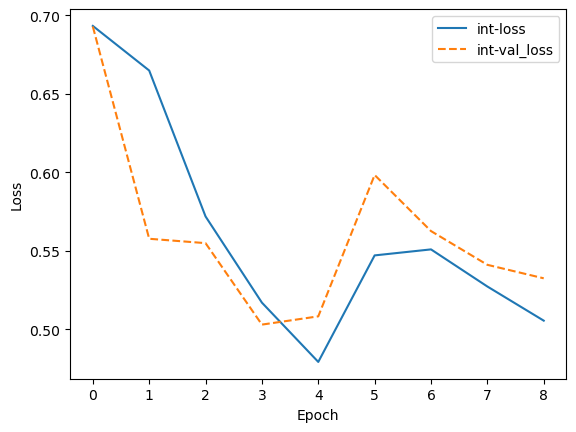

In [10]:
plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Test performance of model

In [11]:
# Test it with `raw_test_ds`
loss, accuracy = int_model.evaluate(raw_test_ds)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7813 - loss: 0.5128
Accuracy: 0.7807999849319458
Loss: 0.51230388879776


## Make predictions on the test dataset.

In [12]:
true_labels = []
texts = []
predicted_labels = []

for text_batch, label_batch in raw_test_ds:
    batch_predictions = int_model.predict(text_batch, verbose=0)
    batch_predicted_labels = (batch_predictions > 0.5).astype(int)

    texts.extend([text.decode('utf-8') for text in text_batch.numpy()])
    true_labels.extend(label_batch.numpy())
    predicted_labels.extend(batch_predicted_labels.flatten())

df = pd.DataFrame({
    "Question": texts,
    "True Label": true_labels,
    "Predicted Label": predicted_labels
})

print("Table of all predictions:")
display(df)

Table of all predictions:


,Question,True Label,Predicted Label
0,If you value your freedom!<br /><br />I first ...,1,0
1,Shame on Fox for dumping this movie. It was a ...,1,0
2,This movie was a modern day scarface.It had me...,1,1
3,This movie was borderline in crude humor....I ...,1,0
4,A kinda remake of PLANES TRAINS AND AUTOMOBILE...,1,0
...,...,...,...
24995,"Although Flatliners is 15 years old, tonight w...",1,1
24996,"First, I don't see how the movie is on any ""be...",0,0
24997,"In Moscow, the priest Owen (Vincent Gallo) hir...",0,0
24998,"I saw this film much like Skywalker02 did, but...",1,1


In [13]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.7808
Precision: 0.8517739025856885
Recall: 0.67992
F1 Score: 0.7562060681555298


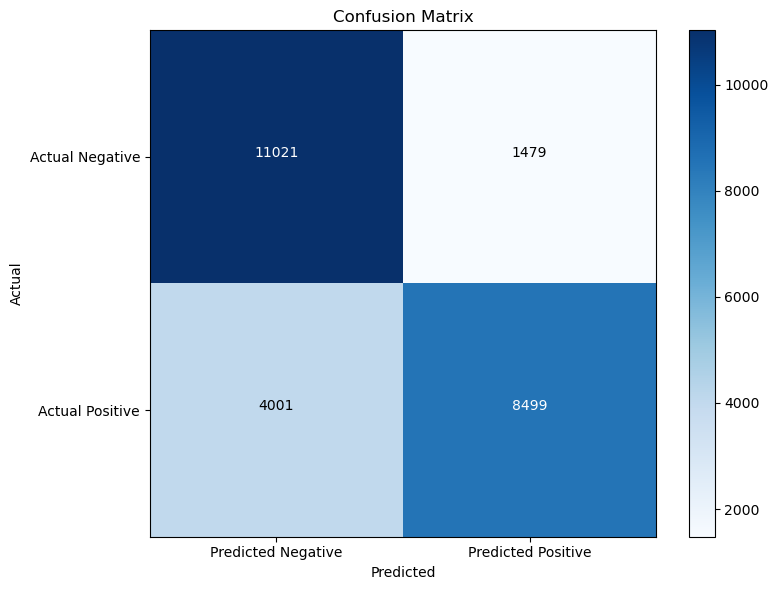

In [14]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()